In [1]:
import os
# set GPU number. This might work for several framework such as PyTorch, TensorFlow, Keras
gpu_id = '0'
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# sys.path.append('../../loglizer')
    
# from loglizer import dataloader
# from loglizer.preprocessing import Vectorizer, Iterator
import sys
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import Dataset
import torch.utils.data as Data
from torch.autograd import Variable
import pickle as pkl
import argparse
import time
import copy
import torchvision.transforms as transforms
import torchvision
import random
from collections import OrderedDict
from PIL import Image

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from collections import defaultdict

from torch.nn.utils import clip_grad_norm_
from torch.distributions.laplace import Laplace

from _utils import clip_generator, add_noise_generator

In [4]:
# struct_log = '../data/HDFS/HDFS.log_structured.csv' # The structured log file

#初始參數
class Parser():
    def __init__(self):
        self.mode = 'fedadam'  #FedBN,FedAvg,fedprox,fedopt,fedadagrad,fedadam 待加入scoffold
        #所有方法都有使用Fedbn
        self.beta_1 = 0.9
        self.beta_2 = 0.99 #b1,b2 for adaptive opt
        self.tau = 1e-2
        self.batch = 32
        self.lr = 1e-1
        self.server_lr = 1e-1
        self.server_momentum = 0.5
        self.client_momentum = 0.9 # 0 is fedavg others is fedavgm
        self.no_cuda = False
        self.seed = 1
        self.client_num = 5
        self.wk_iters = 1 # training
        self.num_workers = 2 # dataloader
        self.mu = 1e-3
        self.iters = 1 #epochs
        self.local_epochs = 10
        self.server_opt = 'sgd'
        self.percent = 1
#         self.early_stop = 500
        self.window_size = 10
        self.train_ratio = 0.5
        self.split_type='sequential' # sequential, uniform
        self.max_grad_norm = 1.0

        
args = Parser()

use_cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed) 
random.seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

group = {'noise_scale':0.03, 'norm_bound':1.5}
# 0 0.01 0.03 0.05 0.07 0.10

In [5]:
sys.path.append('../')
from logdeep.tools.predict_sl_dp import Predicter
from logdeep.tools.train_sl_dp import Trainer
from logdeep.tools.utils import *

# Config Parameters

options = dict()
options['data_dir'] = '../data/'
options['window_size'] = 10
options['device'] = device

# Smaple
options['sample'] = "sliding_window"
options['window_size'] = 10  # if fix_window

# Features
options['sequentials'] = True
options['quantitatives'] = True
options['semantics'] = False
options['feature_num'] = sum(
    [options['sequentials'], options['quantitatives'], options['semantics']])

# Model
options['input_size'] = 1
options['hidden_size'] = 64
options['num_layers'] = 2
options['num_classes'] = 28

# Train
options['batch_size'] = 2048
options['accumulation_step'] = 1

options['optimizer'] = 'adam'
options['lr'] = 1e-2
options['max_epoch'] = args.local_epochs
options['lr_step'] = (300, 350)
options['lr_decay_ratio'] = 0.1

options['resume_path'] = None
options['model_name'] = "loganomaly"
options['save_dir'] = "../result/loganomaly/"

# Predict
options['model_path'] = "../result/loganomaly/loganomaly_last.pth"
options['num_candidates'] = 9

seed_everything(seed=1234)


def train():
    trainer = Trainer(Model, options)
    trainer.start_train()


def predict():
    predicter = Predicter(Model, options)
    predicter.predict_unsupervised()

# Preprocessing

In [6]:
class loganomaly(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, device):
        input0, input1 = features[0], features[1]

        h0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)
        c0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (h0_0, c0_0))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, _ = self.lstm1(input1, (h0_1, c0_1))
        multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
        out = self.fc(multi_out)
        return out
    
class loganomaly_1st(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly_1st, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
#         self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, device):
        input0, input1 = features[0], features[1]

        h0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)
        c0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (h0_0, c0_0))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, (outpreh, outprec) = self.lstm1(input1, (h0_1, c0_1))
#         multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
#         out = self.fc(multi_out)
        return out1, outpreh, outprec


class loganomaly_2nd(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly_2nd, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, hPrevious, cPrevious, device):
        input0, input1 = features[0], features[1]

#         h0_0 = torch.zeros(self.num_layers, input0.size(0),
#                            self.hidden_size).to(device)
#         c0_0 = torch.zeros(self.num_layers, input0.size(0),
#                            self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (hPrevious, cPrevious))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, _ = self.lstm1(input1, (h0_1, c0_1))
        multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
        out = self.fc(multi_out)
        return out

# Federated learning

In [7]:
def communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2):
    if args.mode.lower() == 'fedbn':
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_1.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]
                    server_model_1.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
            for key in server_model_2.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_2.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]
                    server_model_2.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])
    
    elif args.mode.lower() == 'fedadagrad':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_1[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_1[key] = param.grad
                v_1[key] = v_1[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])                         
            for key, param in server_model_2.named_parameters():
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_2[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_2[key] = param.grad
                v_2[key] = v_2[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key]) 
    
    elif args.mode.lower() == 'fedadam':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():
                clip = clip_generator(norm_bound=group['norm_bound'])
                add_noise = add_noise_generator(noise_scale=group['noise_scale'] * group['norm_bound'])
                
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                         
                param.grad = temp - param.data   
                param.grad = add_noise(clip(param.grad))
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_1[key] = param.grad    
                
                #梯度裁剪
                
                v_1[key] = torch.mul(v_1[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr)
                
#                 big1 = torch.max(param.data)
#                 clip_grad_norm_(param.data, max_norm = big1)
#                 m1 = Laplace(torch.tensor([0.0]).to(device),  torch.tensor([1.0]).to(device)) # scale=sensitivity/epsilon
#                 param.data = torch.add(param.data, m1.sample())
                
                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
            for key, param in server_model_2.named_parameters():       
                clip = clip_generator(norm_bound=group['norm_bound'])
                add_noise = add_noise_generator(noise_scale=group['noise_scale'] * group['norm_bound'])
                
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]                         
                param.grad = temp - param.data   
                param.grad = add_noise(clip(param.grad))
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_2[key] = param.grad                
                v_2[key] = torch.mul(v_2[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr)
                
#                 big2 = torch.max(param.data)
#                 clip_grad_norm_(param.data, max_norm = big2)
#                 m2 = Laplace(torch.tensor([0.0]).to(device), torch.tensor([1.0]).to(device)) # scale=sensitivity/epsilon
#                 param.data = torch.add(param.data, m2.sample())
                
                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])

    else:
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_1.state_dict()[key].data.copy_(models_1[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_1.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                        
                    server_model_1.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])  
            for key in server_model_2.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_2.state_dict()[key].data.copy_(models_2[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_2.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]                        
                    server_model_2.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])  
    return server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2

In [8]:
# # setup model
server_model_1 = loganomaly_1st(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
server_model_2 = loganomaly_2nd(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
# for adaptive velocity
v_1 = {}
grad_1 = {}
v_2 = {}
grad_2 = {}

for key in server_model_1.state_dict().keys():
    v_1[key] = torch.add(torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_1[key] = torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32)
for key in server_model_2.state_dict().keys():
    v_2[key] = torch.add(torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_2[key] = torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32)
    
# name of each datasets
datasets = ['Client'+str(i) for i in range(args.client_num)]
# federated client number
client_num = len(datasets)
client_weights = [1/client_num for i in range(client_num)]
# each local client model
models_1 = [copy.deepcopy(server_model_1).to(device) for idx in range(client_num)]
models_2 = [copy.deepcopy(server_model_2).to(device) for idx in range(client_num)]

start_iter = 0

# lloogg_1 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
#           'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
# lloogg_2 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
#           'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
# lloogg_3 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
#           'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
# lloogg_4 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
#           'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
# lloogg_5 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
#           'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
for i in range(args.client_num):
    exec('lloogg_'+str(i+1)+ " = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]},'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}")

result_recall = {}
result_precision = {}
result_f1 = {}
result_acc = {}
for i in range(client_num):
    result_recall[i] = []
    result_precision[i] = []
    result_f1[i] = []
    result_acc[i] = []

# Start training
for a_iter in range(start_iter, args.iters):
#     optimizers = [optim.SGD(params = models[idx].parameters(), lr=args.lr, momentum = args.client_momentum) for idx in range(client_num)]
    for wi in range(args.wk_iters):
        print("============ Train epoch {} ============".format(wi + a_iter * args.wk_iters))
        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            trainer = Trainer(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            trainer.start_train()
            
            exec('lloogg_'+str(client_idx+1)+"['train']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['train']['lr'].append(trainer.log['train']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['time'].append(trainer.log['train']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['loss'].append(trainer.log['train']['loss'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['val']['lr'].append(trainer.log['valid']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['time'].append(trainer.log['valid']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['loss'].append(trainer.log['valid']['loss'][-1])")

    with torch.no_grad():
        # aggregation
        server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2 = communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2 )
        # Report loss after aggregation
        print("============ Test epoch {} ============".format(wi + a_iter * args.wk_iters))

        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            predicter = Predicter(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            predicter.predict_unsupervised()
            
            result_recall[client_idx].append(predicter.recall)
            result_precision[client_idx].append(predicter.precision)
            result_f1[client_idx].append(predicter.f1)
            result_acc[client_idx].append(predicter.acc)

============ Train epoch 0 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▌                                                                         | 74/1058 [00:00<00:01, 734.36it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:21:57 | Learning rate: 0.000313


Train loss: 3.23454:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 1 | phase: train | ⏰: 03:22:05 | Learning rate: 0.000625
Starting epoch: 2 | phase: train | ⏰: 03:22:05 | Learning rate: 0.001250


Train loss: 1.92775:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 3 | phase: train | ⏰: 03:22:06 | Learning rate: 0.002500
Starting epoch: 4 | phase: train | ⏰: 03:22:06 | Learning rate: 0.005000


Train loss: 1.74870:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 5 | phase: train | ⏰: 03:22:06 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 03:22:06 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 03:22:06 


Train loss: 1.30817:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Validation loss: 1.3902984857559204
Starting epoch: 7 | phase: train | ⏰: 03:22:06 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 03:22:07 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 03:22:07 


Train loss: 0.95374: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.59it/s]

Validation loss: 0.9939876198768616
Starting epoch: 9 | phase: train | ⏰: 03:22:07 | Learning rate: 0.010000
Client  1


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▍                                                                        | 85/1046 [00:00<00:01, 841.60it/s]

sampling...


Train loss: 3.37052:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:22:17 | Learning rate: 0.000313


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 1 | phase: train | ⏰: 03:22:18 | Learning rate: 0.000625
Starting epoch: 2 | phase: train | ⏰: 03:22:18 | Learning rate: 0.001250


Train loss: 1.92491:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 3 | phase: train | ⏰: 03:22:18 | Learning rate: 0.002500
Starting epoch: 4 | phase: train | ⏰: 03:22:18 | Learning rate: 0.005000


Train loss: 1.70829:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 5 | phase: train | ⏰: 03:22:18 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 03:22:19 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 03:22:19 


Train loss: 1.29556:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 27.51it/s]

Validation loss: 1.321800947189331
Starting epoch: 7 | phase: train | ⏰: 03:22:19 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 03:22:19 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 03:22:19 


Train loss: 0.94607: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.07it/s]


Validation loss: 0.9649931192398071
Starting epoch: 9 | phase: train | ⏰: 03:22:19 | Learning rate: 0.010000
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 10%|███████▌                                                                     | 104/1051 [00:00<00:00, 1040.00it/s]

sampling...


Train loss: 3.37384:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:22:30 | Learning rate: 0.000313


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 1 | phase: train | ⏰: 03:22:31 | Learning rate: 0.000625
Starting epoch: 2 | phase: train | ⏰: 03:22:31 | Learning rate: 0.001250


Train loss: 2.48117:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 3 | phase: train | ⏰: 03:22:31 | Learning rate: 0.002500


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 03:22:31 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 03:22:31 | Learning rate: 0.010000


Train loss: 1.55534:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.86it/s]

Starting epoch: 6 | phase: train | ⏰: 03:22:31 | Learning rate: 0.010000


Train loss: 1.35389:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.68it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:22:32 
Validation loss: 1.4107173681259155
Starting epoch: 7 | phase: train | ⏰: 03:22:32 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 03:22:32 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 03:22:32 


Train loss: 0.99378: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.74it/s]


Validation loss: 1.056980013847351
Starting epoch: 9 | phase: train | ⏰: 03:22:32 | Learning rate: 0.010000
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 10%|███████▎                                                                     | 101/1057 [00:00<00:00, 1010.00it/s]

sampling...


Train loss: 3.37097:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:22:43 | Learning rate: 0.000313


Train loss: 3.28987:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 03:22:43 | Learning rate: 0.000625


Train loss: 3.15879:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 2 | phase: train | ⏰: 03:22:43 | Learning rate: 0.001250


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 3 | phase: train | ⏰: 03:22:44 | Learning rate: 0.002500
Starting epoch: 4 | phase: train | ⏰: 03:22:44 | Learning rate: 0.005000


Train loss: 1.73794:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.39it/s]

Starting epoch: 5 | phase: train | ⏰: 03:22:44 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 03:22:44 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 03:22:44 


Train loss: 1.26462:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 26.32it/s]

Validation loss: 1.3246301412582397
Starting epoch: 7 | phase: train | ⏰: 03:22:44 | Learning rate: 0.010000


Train loss: 1.05001:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.21it/s]

Starting epoch: 8 | phase: train | ⏰: 03:22:45 | Learning rate: 0.010000


Train loss: 0.96814:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 26.32it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:22:45 
Validation loss: 0.9101400971412659
Starting epoch: 9 | phase: train | ⏰: 03:22:45 | Learning rate: 0.010000


Train loss: 0.96814: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.57it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▌                                                                     | 103/1044 [00:00<00:00, 1019.80it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:22:55 | Learning rate: 0.000313


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 1 | phase: train | ⏰: 03:22:56 | Learning rate: 0.000625
Starting epoch: 2 | phase: train | ⏰: 03:22:56 | Learning rate: 0.001250


Train loss: 2.46439:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 26.09it/s]

Starting epoch: 3 | phase: train | ⏰: 03:22:56 | Learning rate: 0.002500


Train loss: 1.78416:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 03:22:56 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 03:22:57 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 03:22:57 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 03:22:57 


Train loss: 1.30984:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 26.79it/s]

Validation loss: 1.354272723197937
Starting epoch: 7 | phase: train | ⏰: 03:22:57 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 03:22:57 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 03:22:57 


Train loss: 0.94413:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Validation loss: 0.9622112512588501
Starting epoch: 9 | phase: train | ⏰: 03:22:57 | Learning rate: 0.010000


Train loss: 0.94413: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.64it/s]


============ Test epoch 0 ============
Client  0


  0%|                                                                                         | 0/5813 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:13<00:00, 83.11it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 141.70759177207947
Client  1


  0%|                                                                                 | 8/5574 [00:00<01:16, 72.73it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:14<00:00, 79.21it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 135.49342226982117
Client  2


  0%|                                                                                 | 8/5730 [00:00<01:20, 71.43it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:14<00:00, 79.35it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.99337553977966
Client  3


  0%|                                                                                 | 7/5747 [00:00<01:30, 63.64it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:14<00:00, 78.29it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.95066118240356
Client  4


  0%|                                                                                 | 7/5623 [00:00<01:22, 67.96it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:14<00:00, 79.19it/s]

false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 136.11405873298645


In [9]:
predicter_s = Predicter(server_model_1, server_model_2, options, 1, 0)
predicter_s.predict_unsupervised()

  0%|                                                                                | 5/14177 [00:00<06:02, 39.06it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:52<00:00, 78.14it/s]

false positive (FP): 2462, false negative (FN): 139, Precision: 87.151%, Recall: 99.174%, F1-measure: 92.775%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.544
Finished Predicting
elapsed_time: 376.4436283111572


In [10]:
for i in range(args.client_num):
    exec('''for key, values in lloogg_''' + str(i+1) + '''.items():
        pd.DataFrame(values).to_csv('../result/1e/la/fedadam_10e_12_0.03/client_'''+str(i+1)+'''_' + key + '_log.csv', index=False)''')
    del key 
    del values

In [11]:
(pd.DataFrame.from_dict(data=result_recall, orient='index').to_csv('../result/1e/la/fedadam_10e_12_0.03/recall.csv', header=False))
(pd.DataFrame.from_dict(data=result_precision, orient='index').to_csv('../result/1e/la/fedadam_10e_12_0.03/precision.csv', header=False))
(pd.DataFrame.from_dict(data=result_f1, orient='index').to_csv('../result/1e/la/fedadam_10e_12_0.03/f1.csv', header=False))
(pd.DataFrame.from_dict(data=result_acc, orient='index').to_csv('../result/1e/la/fedadam_10e_12_0.03/acc.csv', header=False))

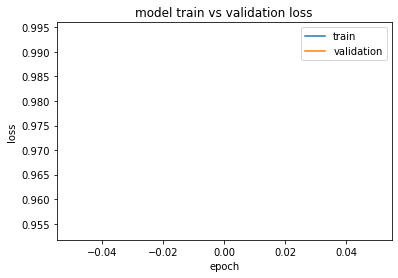

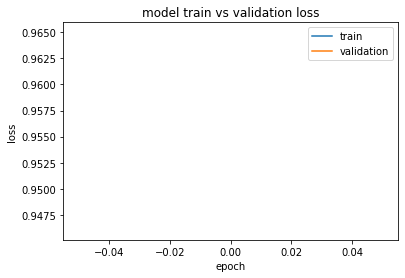

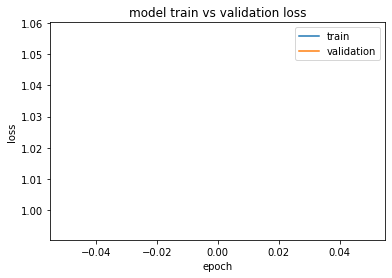

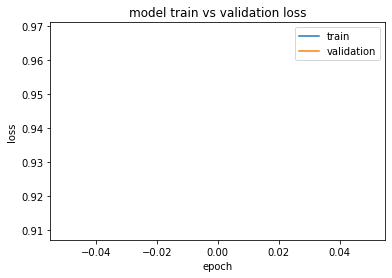

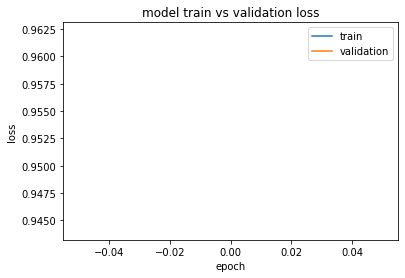

In [12]:
# plot train and validation loss
for i in range(args.client_num):
    exec("plt.plot(lloogg_"+str(i+1) + "['train']['epoch'], lloogg_"+str(i+1)+"['train']['loss'])")
    exec("plt.plot(lloogg_"+str(i+1) + "['val']['epoch'], lloogg_"+str(i+1) + "['val']['loss'])")
    exec("plt.title('model train vs validation loss')")
    exec("plt.ylabel('loss')")
    exec("plt.xlabel('epoch')")
    exec("plt.legend(['train', 'validation'], loc='upper right')")
    exec("plt.show()")

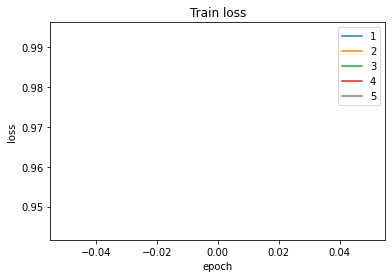

In [13]:
t = []
for i in range(args.client_num):
    exec("plt.plot(lloogg_"+str(i+1) + "['train']['epoch'], lloogg_"+str(i+1)+"['train']['loss'])")
    t.append(str(i+1))
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(t, loc='upper right')
plt.show()

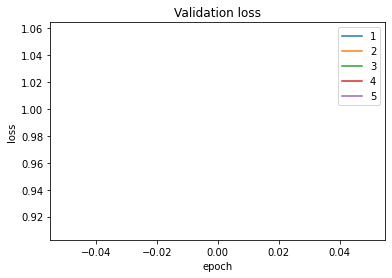

In [14]:
t = []
for i in range(args.client_num):
    exec("plt.plot(lloogg_"+str(i+1) + "['val']['epoch'], lloogg_"+str(i+1)+"['val']['loss'])")
    t.append(str(i+1))
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(t, loc='upper right')
plt.show()

In [15]:
result_record_f1 = pd.DataFrame.from_dict(data=result_f1, orient='index')
result_record_f1 = np.mean(np.array(result_record_f1), axis = 0)
result_record_f1 = result_record_f1.reshape(-1)

result_record_acc = pd.DataFrame.from_dict(data=result_acc, orient='index')
result_record_acc = np.mean(np.array(result_record_acc), axis = 0)
result_record_acc = result_record_acc.reshape(-1)

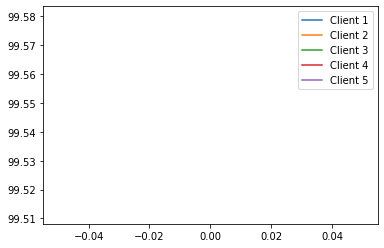

In [16]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_acc[i], label = 'Client '+ str(i+1))
plt.legend()
plt.show()

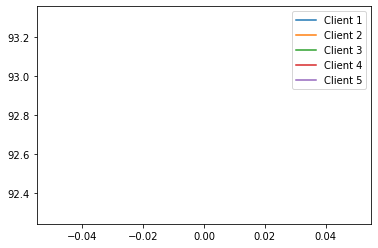

In [17]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_f1[i], label =  'Client '+ str(i+1))
plt.legend()
plt.show()